In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
gme_df = pd.read_csv("../stock_prices/Gamestop_2020-2022.csv", index_col=0)
reddit_ts = pd.read_csv("../explorative/wsb_timeseries_2.csv", low_memory=False, index_col=0)
# gme_df.plot()
reddit_ts.head(10)

,word_count
date,
2020-12-01,90
2020-12-02,64
2020-12-03,27
2020-12-04,47
2020-12-05,31
2020-12-06,27
2020-12-07,42
2020-12-08,78
2020-12-09,103


In [4]:
reddit_ts.shape

(669, 1)

### Plotting

In [5]:
# Prepare word-count for plotting
gme_df["Open"]

Date
2020-11-27     3.822500
2020-11-30     4.542500
2020-12-01     4.277500
2020-12-02     3.925000
2020-12-03     4.120000
                ...    
2022-11-18    28.160000
2022-11-21    26.660000
2022-11-22    25.129999
2022-11-23    25.920000
2022-11-25    26.500000
Name: Open, Length: 503, dtype: float64

In [6]:
plotting_df = pd.DataFrame(gme_df)
plotting_df["wordcount"] = reddit_ts["word_count"] # reddit_ts["aggregat"]
plotting_df.replace(np.nan, 0, inplace=True)

# Normalize Wordcount
factor = plotting_df["wordcount"].max()/plotting_df["Open"].max()
plotting_df["wordcount"] = plotting_df["wordcount"]/factor

# Index to datetime format
plotting_df.index = pd.DatetimeIndex(plotting_df.index)
plotting_df.head(10)

,Open,wordcount
Date,,
2020-11-27,3.8225,0.000000
2020-11-30,4.5425,0.000000
2020-12-01,4.2775,0.297092
2020-12-02,3.9250,0.211265
2020-12-03,4.1200,0.089128
2020-12-04,4.0750,0.155148
2020-12-07,4.2500,0.138643
2020-12-08,4.0925,0.257480
2020-12-09,3.4800,0.340005


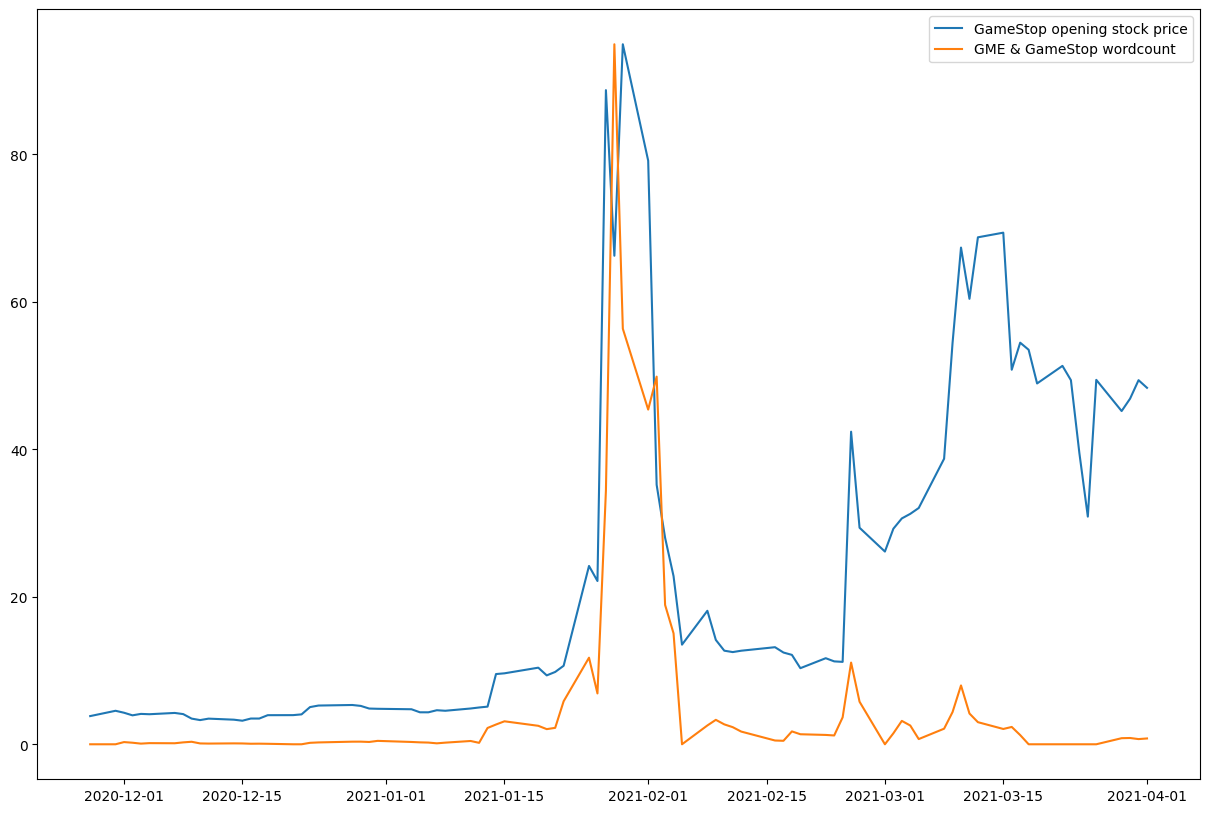

In [7]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(plotting_df["Open"].loc[:"2021-04-01"], label="GameStop opening stock price")
ax.plot(plotting_df["wordcount"].loc[:"2021-04-01"], label="GME & GameStop wordcount")
ax.legend()
plt.show()

### Checking for offset
Determine by how much the reddit TS can serve as early indicator for the stock price.

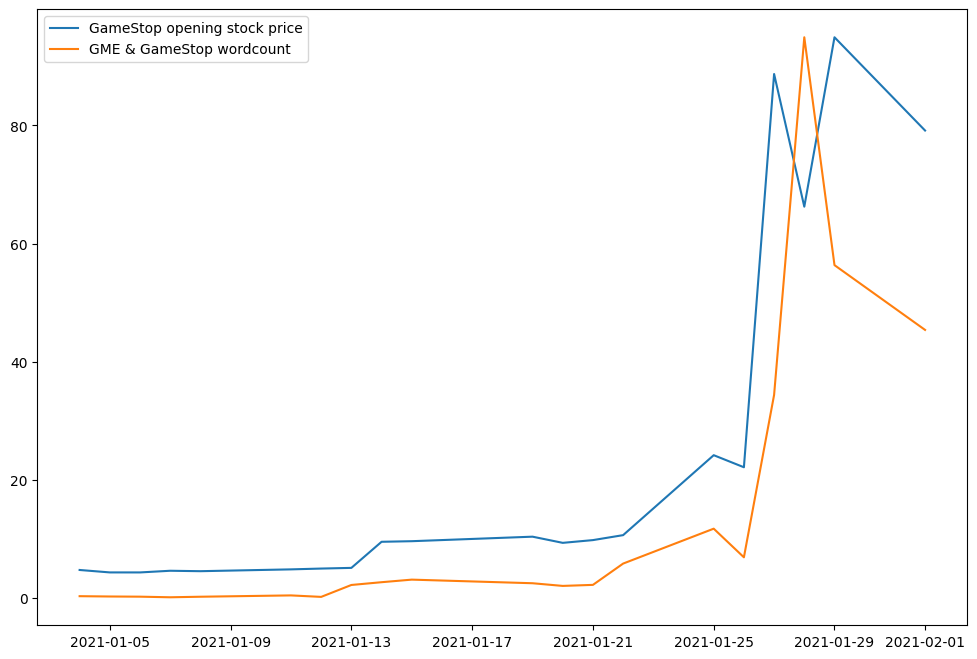

In [56]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(plotting_df["Open"].loc["2021-01-01":"2021-02-01"], label="GameStop opening stock price") # .shift(-1)
ax.plot(plotting_df["wordcount"].loc["2021-01-01":"2021-02-01"], label="GME & GameStop wordcount")
ax.legend()
plt.show()

In [54]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    
    if not wrap:
        return datax.corr(datay.shift(lag))
    shiftedy = datay.shift(lag)
    shiftedy.iloc[:lag] = datay.iloc[-lag:].values
    return datax.corr(shiftedy)

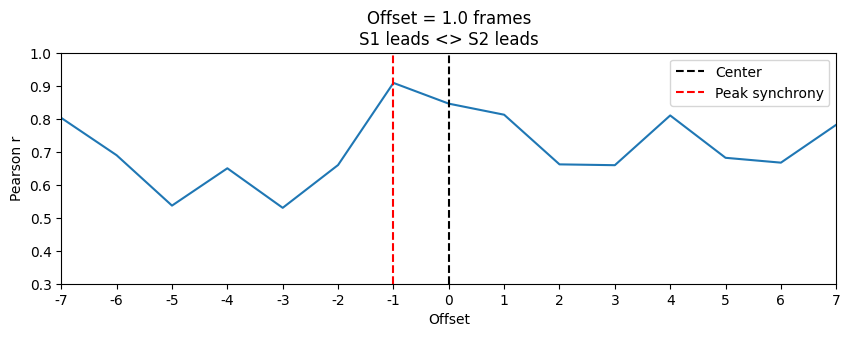

In [55]:
d1 = plotting_df["Open"].loc["2021-01-01":"2021-02-01"]
d2 = plotting_df["wordcount"].loc["2021-01-01":"2021-02-01"]
seconds = 1
fps = 7
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(10,3))
ax.plot(rs)
ax.axvline(fps, color='k', linestyle='--', label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.3,1],xlim=[0,10], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks(list(range(fps*2+1)))
ax.set_xticklabels(list(range(-fps, fps+1)))
plt.legend()
plt.show()